In [1]:
import numpy as np
from tqdm import tqdm
from scipy.special import erf
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
rng = np.random.default_rng()

## Model Training

In [2]:
N_Aiv = 300
conn_prob = 1

In [3]:
peak_rate, kernel_width = 150, 10

In [4]:
T_rend = 100 # Each rendition
N_rend = 20 # Number of renditions
T = N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
syl = rng.normal(0, 1, size=(1, N_Aiv))
# ( 1, Number of renditions )
burst_ts = np.array([[T_rend * (j + 1/2) for j in range(N_rend)]])
save_W_ts = (burst_ts[0] + T_rend / 2 - 1).astype(int) # [0] to squeeze

In [6]:
_ = rng.standard_normal((1, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
aud = np.tile(syl, (T, 1))

In [8]:
rmax, s, th = 100, 1, 4
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [9]:
def bilin_hebb(W, aiv, hvc, lr, w0_mean, tau_w):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * aiv * h - (W[:,i] - w0_mean) / tau_w
        W[:,i] = np.clip(W[:,i] + dW, a_min=0, a_max=None)

In [10]:
w0_mean, w0_std = 1, 0.1
JEE, JEI, JIE, JII = np.array([1, 2, 1, 0.5]) * 0.3
tau_Aiv, tau_I, dt = 20, 10, 1

net = Aiv(N_Aiv, 1, conn_prob, w0_mean, w0_std, phi, tau_Aiv,
          tau_I, JEE, JEI, JIE, JII)

Aiv0, I0, ext_I = phi(rng.normal(0, 1, size=N_Aiv)), 1, 0

_ = net.sim(Aiv0, I0, rH, aud, save_W_ts, T, dt, 0.1, ext_I, bilin_hebb,
            lr=-5e-7, w0_mean=w0_mean, tau_w=5e7)
rA, rI, Ws, mean_HVC_input = _

[Text(0.5, 0, 'Time (a.u.)'), Text(0, 0.5, 'mean input\nfrom HVC')]

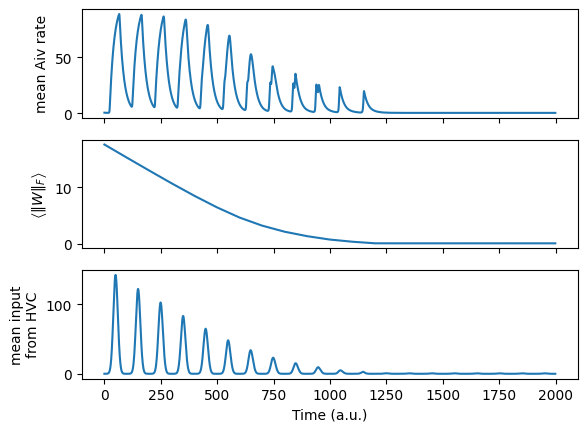

In [11]:
W_norms = np.array([np.linalg.norm(_, ord='fro') for _ in Ws]) # Frobenius norm
fig, ax = plt.subplots(3, sharex='all')
ax[0].plot(rA.mean(axis=1))
ax[1].plot(np.hstack([[0], save_W_ts]), W_norms)
ax[2].plot(mean_HVC_input)
ax[0].set(ylabel='mean Aiv rate')
ax[1].set(ylabel=r'$\left\langle \| W \|_F \right\rangle$')
ax[2].set(xlabel='Time (a.u.)', ylabel='mean input\nfrom HVC')

In [12]:
W_syl_corrs = [correlation(_.T, syl, dim=1) for _ in Ws]

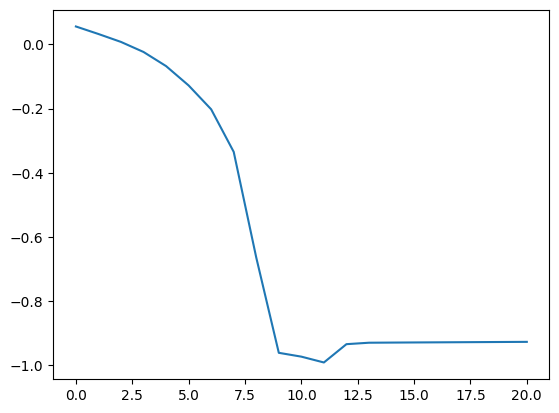

In [13]:
plt.plot(list(map(lambda x: x.flatten(), W_syl_corrs)))

0.7377737619100582

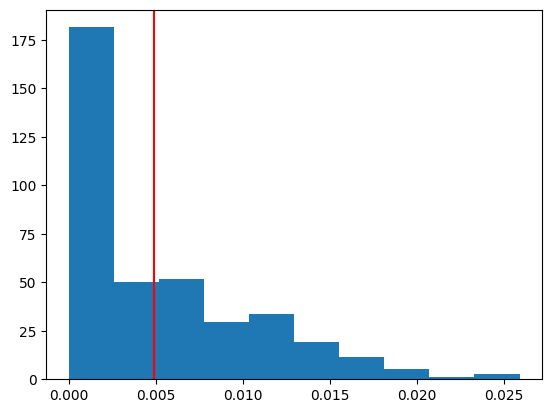

In [14]:
plt.hist(Ws[-1].flatten(), density=True, bins=10)
plt.axvline(Ws[-1].mean(), color='r')
# plt.axvline(w0_mean, color='k')
Ws[-1].mean() * peak_rate

## Error Code for Deterministic Perturbation

In [15]:
def plot_joint_dist(x, y, x_name, y_name, cond, cond_name):
    '''
    x, y: (Number of conditions, Time, Number of Aiv)
    cond: conditions or conditional vars
    '''
    fig, ax = plt.subplots(1, len(cond), sharex='all', sharey='row', 
                           figsize=(len(cond)*2, 2.5))
    if len(cond) == 1:
        ax = [ax]
    cmap = colormaps.get_cmap('viridis')
    for i in range(len(cond)):
        ax[i].scatter(x[i], y[i], s=3)
        ax[i].set(title=cond_name + '= %.2f' % cond[i], xlabel=x_name)
    ax[0].set_ylabel(y_name)
    fig.tight_layout()
    return fig, ax

In [16]:
def deterministic_perturb(eps0s, rH=peak_rate):
    Aiv0, I0 = np.ones(N_Aiv), 1
    _T_rend, dt = 5000, 0.1
    
    rH_ = np.zeros((_T_rend, 1)) + rH

    rA = np.zeros((len(eps0s), _T_rend, N_Aiv))
    
    aud_ = np.tile(syl, (_T_rend, 1))
    for i in tqdm(range(len(eps0s))):
        aud_[_T_rend//2:] = eps0s[i]
        res = net.sim(Aiv0, I0, rH_, aud_, [], _T_rend, dt, 0, ext_I)[0]
            
        rA[i] = res
    return rA

In [17]:
eps0s = (-1.4, -0.8, -0.2, 0, 0.2, 0.8, 1.4)
rAs = deterministic_perturb(eps0s)

100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  3.67it/s]


[Text(0, 0.5, '$\\bar r^A$'), Text(0.5, 0, 'Time')]

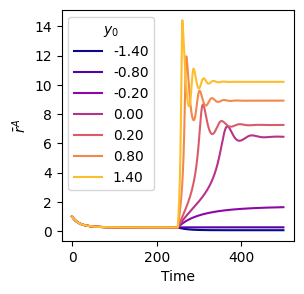

In [25]:
fig, ax = plt.subplots(1, figsize=(3,3))
_ = np.arange(0, rAs.shape[1] * 0.1, 0.1)
cmap = colormaps.get_cmap('plasma')
for i, eps0 in enumerate(eps0s):
    ax.plot(_, rAs[i].mean(axis=-1), c=cmap(i/len(eps0s)),
            label='%.2f' % eps0)
ax.legend(title='$y_0$')
ax.set(ylabel=r'$\bar r^A$', xlabel='Time')

In [19]:
rA_pre, rA_post = rAs[:,:rAs.shape[1]//2], rAs[:,rAs.shape[1]//2:]

[(-1.0, 8.0)]

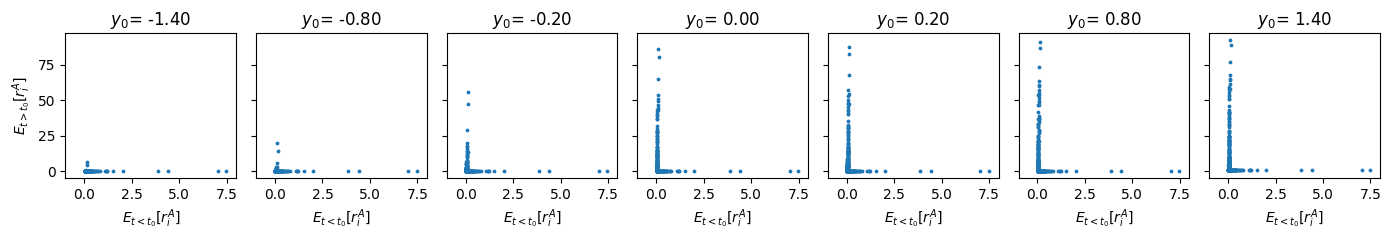

In [20]:
fig, ax = plot_joint_dist(rA_pre[:,-500:].mean(axis=1), rA_post[:,-500:].mean(axis=1),
                          r'$E_{t < t_0}[r^A_i]$', r'$E_{t > t_0}[r^A_i]$', 
                          eps0s, r'$y_0$');
ax[0].set(xlim=[-1, 8])

[(-5.0, 8.0), (-1.0, 10.0)]

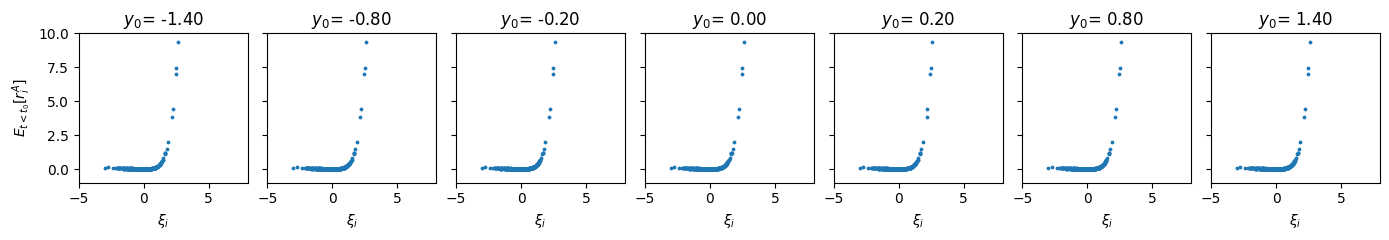

In [26]:
fig, ax = plot_joint_dist(np.tile(syl, (len(eps0s), 1)), rA_pre[:,-500:].mean(axis=1),
                          r'$\xi_i$', r'$E_{t < t_0}[r^A_i]$', 
                          eps0s, r'$y_0$');
ax[0].set(xlim=[-5, 8], ylim=[-1, 10])

[(-5.0, 8.0)]

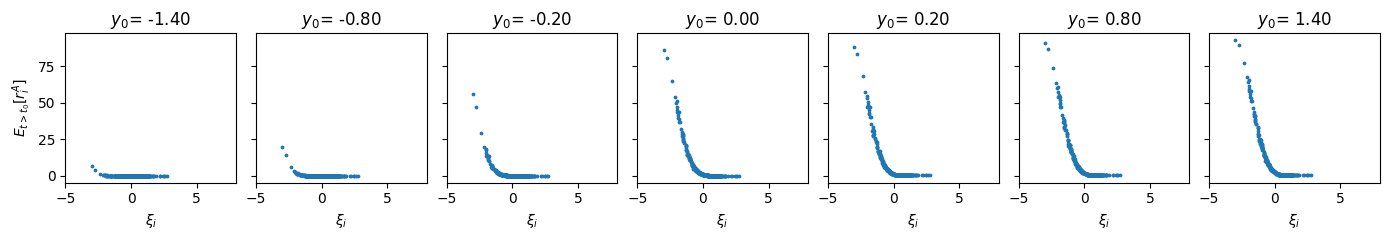

In [22]:
fig, ax = plot_joint_dist(np.tile(syl, (len(eps0s), 1)), rA_post[:,-500:].mean(axis=1),
                          r'$\xi_i$', r'$E_{t > t_0}[r^A_i]$', 
                          eps0s, r'$y_0$');
ax[0].set(xlim=[-5, 8])

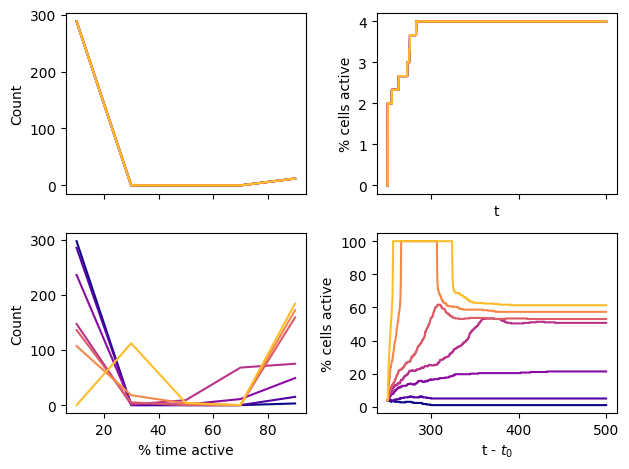

In [55]:
fig, ax = plt.subplots(2, 2, sharex='col')
act_pre, act_post = rA_pre > 1, rA_post > 1
cmap = colormaps.get_cmap('plasma')
for i in range(len(eps0s)):
    hist, x = np.histogram(act_pre[i].mean(axis=-2), bins=5, range=(0, 1))
    x = x[:-1] + (x[1] - x[0]) / 2
    ax[0,0].plot(x * 100, hist, c=cmap(i/len(eps0s)))
    ax[0,0].set(ylabel='Count')
    
    hist, x = np.histogram(act_post[i].mean(axis=-2), bins=5, range=(0, 1))
    x = x[:-1] + (x[1] - x[0]) / 2
    ax[1,0].plot(x * 100, hist, c=cmap(i/len(eps0s)))
    ax[1,0].set(ylabel='Count', xlabel='% time active')

    _ = np.arange(rAs.shape[1] / 2 * 0.1, rAs.shape[1] * 0.1, 0.1)
    ax[0,1].plot(_, act_pre[i].mean(axis=-1).T * 100, c=cmap(i/len(eps0s)))
    ax[0,1].set(ylabel='% cells active', xlabel='t')
    ax[1,1].plot(_, act_post[i].mean(axis=-1).T * 100, c=cmap(i/len(eps0s)))
    ax[1,1].set(ylabel='% cells active', xlabel='t - $t_0$')
fig.tight_layout()